In [1]:
# Import packages 
import sys
import argparse as arg

import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# import modules in other directories
sys.path.append('../Regridder/')
import scripGen as SG

import importlib
importlib.reload( SG )

#Rdry = Con.Rdry() # 



<module 'scripGen' from '/glade/work/juliob/PyRegridding/Drivers/../Regridder/scripGen.py'>

 given by

p(\eta) = A(\eta) p_0 + B(\eta) p_s.

In [2]:
def Original_as_bs( px , pcross=0.086 , gridalign=False ):
    m=( (1.0-0.0) / (1.0-pcross ) )
    Lx = len( px )

    if ( gridalign == True ):
        oo=np.where( p58 > pcross )
        pshift = pcross - p58[ oo[0][0]-1 ]
    else:
        pshift=0.0

    hybi_1 = m*(px -pcross +pshift)
    hyai_1 = px
    ##
    hybi_2 = np.where( hybi_1<0. , 0., hybi_1 )
    hyai_2 = px - hybi_2 # - m*pshift
    ###
    hyai_3 = np.where( hyai_2<0. , 0., hyai_2 )
    hybi_3 = px - hyai_3
    
    hyai,hybi = hyai_3, hybi_3
    return hyai,hybi

In [3]:
#####################################
myGridFiles = '/glade/work/juliob/GridFiles/'


In [4]:

L58f = f'{myGridFiles}/Vertical/GRID_48_taperstart10km_lowtop_BL10_v3p1_beta1p75.nc'
L32f = f'{myGridFiles}/Vertical/GRID_32L_CAM6.nc'
#L93f = f'{myGridFiles}/Vertical/GRID_93L_CAM7_c202312.nc'
L93f = f'{myGridFiles}/Vertical/GRID_93L_CAM7_OrigAB_c20240514.nc'
#L93f = '/glade/campaign/cgd/amp/juliob/ERA5/ne30np4/L93/ERA5_x_ne30np4_L93_Test01_WO.1985-01-01-00000.nc'
#L93f='/glade/derecho/scratch/juliob/archive/c153_ne30pg3_FMTHIST_x02/rest/1990-01-01-00000/c153_ne30pg3_FMTHIST_x02.cam.i.1990-01-01-00000.nc'

In [5]:
L32=xr.open_dataset( L32f )
L58=xr.open_dataset( L58f )
L93=xr.open_dataset( L93f )

p58 = L58.hyai.values + L58.hybi.values
p93 = L93.hyai.values + L93.hybi.values

pXX = p93
hyai_in = L93.hyai.values
hybi_in = L93.hybi.values
hyai_58 = L58.hyai.values
hybi_58 = L58.hybi.values


In [6]:
hyaiXX , hybiXX =Original_as_bs(pXX , gridalign=True)

In [7]:
L93

<xarray.Dataset>
Dimensions:  (lev: 93, ilev: 94)
Coordinates:
  * lev      (lev) float64 0.008135 0.01834 0.03482 ... 983.2 991.2 997.5
  * ilev     (ilev) float64 0.004259 0.01201 0.02467 ... 987.4 995.1 1e+03
Data variables:
    hyai     (ilev) float64 4.259e-06 1.201e-05 2.467e-05 ... 0.0005886 0.0 0.0
    hybi     (ilev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.9777 0.9868 0.9951 1.0
    hyam     (lev) float64 ...
    hybm     (lev) float64 ...

[0.00137273 0.00058858 0.         0.        ]
[0.00137273 0.00058858 0.         0.        ]
[0.97765226 0.98677026 0.99505545 1.        ]
[0.97765226 0.98677026 0.99505545 1.        ]


Text(0.5, 1.0, '$\\mathrm{hybrid}~~A(\\eta)~~\\mathrm{and}~~B(\\eta)$')

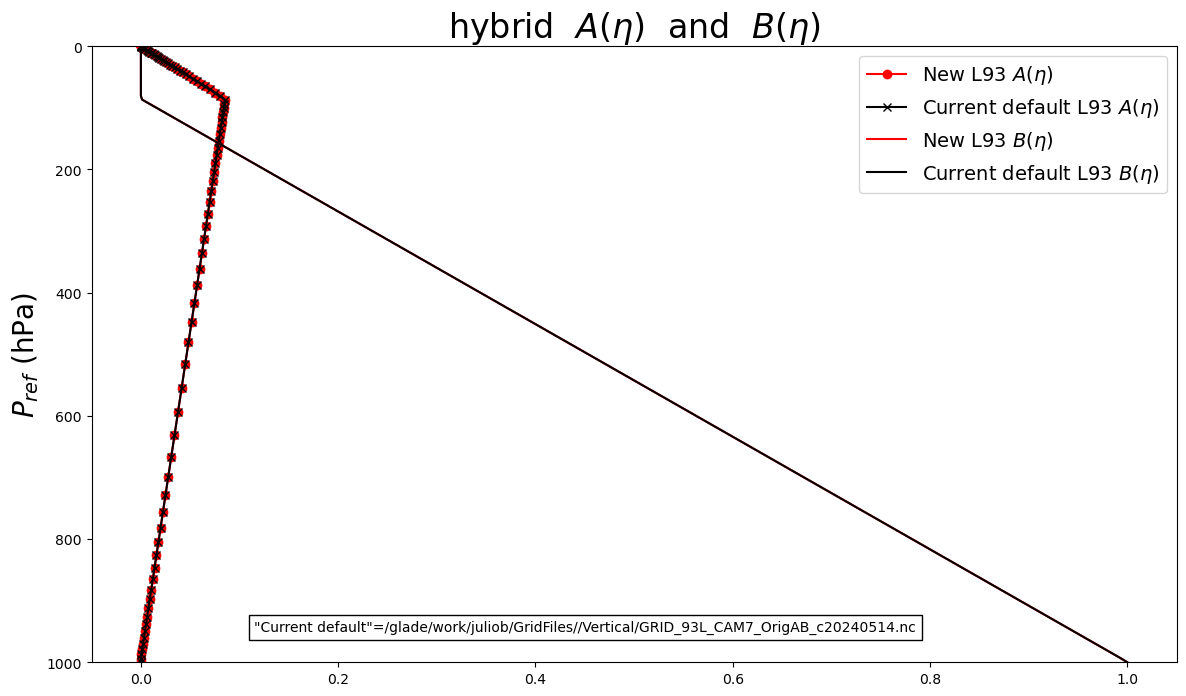

In [11]:
#plt.plot(p58,bb)
#plt.plot(p58,L58.hybi)
#plt.plot(p58,aa)

fig,ax=plt.subplots( 1,1 , squeeze=False, figsize=(14,8) )

ax[0,0].plot(hyaiXX  , 1_000.*pXX, '-o' ,color='red'  , label='New L93 $A(\eta)$' )
ax[0,0].plot(hyai_in , 1_000.*pXX ,'-x', color='black' , label='Current default L93 $A(\eta)$'   )
ax[0,0].plot(hybiXX  , 1_000.*pXX ,color='red' , label='New L93 $B(\eta)$'  )
ax[0,0].plot(hybi_in , 1_000.*pXX, color='black' , label='Current default L93 $B(\eta)$'   )

annot3= ax[0,0].text( 0.15,.05,f'"Current default"={L93f}' , transform=ax[0,0].transAxes, fontsize=10, bbox=dict(facecolor='white') )


print( hyaiXX[-4:] )
print( hyai_in[-4:] )
print( hybiXX[-4:] )
print( hybi_in[-4:] )
plt.ylim( (1000.,0.) )
plt.legend(fontsize=14)
plt.ylabel( "$P_{ref}$ (hPa)" ,fontsize=20)
plt.title( "$\mathrm{hybrid}~~A(\eta)~~\mathrm{and}~~B(\eta)$", fontsize=24 )

In [ ]:
#plt.plot(p58,bb)
#plt.plot(p58,L58.hybi)
#plt.plot(p58,aa)

fig,ax=plt.subplots( 1,1 , squeeze=False, figsize=(14,8) )

ax[0,0].plot(hyaiXX  , 1_000.*pXX, '-o' ,color='red'  , label='New L93 $A(\eta)$' )
ax[0,0].plot(hyai_58 , 1_000.*p58 ,'-x', color='blue' , label='Current default L58 $A(\eta)$'   )
ax[0,0].plot(hybiXX  , 1_000.*pXX ,color='red' , label='New L93 $B(\eta)$'  )
ax[0,0].plot(hybi_58 , 1_000.*p58, color='blue' , label='Current default L58 $B(\eta)$'   )


print( hyaiXX[-4:] )
print( hyai_in[-4:] )
print( hybiXX[-4:] )
print( hybi_in[-4:] )
plt.ylim( (1000.,0.) )
plt.legend(fontsize=14)
plt.ylabel( "$P_{ref}$ (hPa)" ,fontsize=20)
plt.title( "$\mathrm{hybrid}~~A(\eta)~~\mathrm{and}~~B(\eta)$", fontsize=24 )

In [ ]:
#plt.plot(p58,bb)
#plt.plot(p58,L58.hybi)
#plt.plot(p58,aa)

fig,ax=plt.subplots( 1,2 , squeeze=False, figsize=(14,8) )

ax[0,0].plot(pXX,hyaiXX  , 'o' ,color='red')
ax[0,0].plot(pXX,hyai_in ,'x', color='black' )
ax[0,1].plot(pXX,hybiXX  , 'o' ,color='red')
ax[0,1].plot(pXX,hybi_in ,'x', color='black' )


print( hyaiXX[-4:] )
print( hyai_in[-4:] )
print( hybiXX[-4:] )
print( hybi_in[-4:] )



In [ ]:
nzXXe  =len(pXX)
nzXX   =nzXXe-1


hyamXX = np.zeros( nzXX )
hybmXX = np.zeros( nzXX )

for L in np.arange( 0, nzXX, 1):
    hyamXX[L] = 0.5 * ( hyaiXX[L] + hyaiXX[L+1] )
    hybmXX[L] = 0.5 * ( hybiXX[L] + hybiXX[L+1] ) 


In [ ]:
import datetime
# Using the current date
current_date = datetime.datetime.now()
create_date = current_date.strftime('c%Y%m%d')

desc='OrigAB'


ilev = (hyaiXX + hybiXX ) * 1_000. #* 100_000.
lev  = (hyamXX + hybmXX ) * 1_000. #* 100_000.


dims   = ["lev","ilev"]
coords = dict( 
    lev  = ( ["lev"],lev),
    ilev = ( ["ilev"],ilev),
)


NewVgrid = xr.Dataset( coords=coords  )

Dar = xr.DataArray( data=hyaiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyai'] = Dar

Dar = xr.DataArray( data=hybiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybi'] = Dar

Dar = xr.DataArray( data=hyamXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyam'] = Dar

Dar = xr.DataArray( data=hybmXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybm'] = Dar

newname = f'{myGridFiles}/Vertical/GRID_{str(nzXX)}L_CAM7_{desc}_{create_date}.nc'

print(newname) 

In [ ]:
NewVgrid.to_netcdf( newname )

In [ ]:


print( np.min( dzXX[40:70] ) )

fig,ax=plt.subplots( 1,3, squeeze=False, figsize=(20,8)  )

j,i=0,0
psfc = 1_000.
pXX_ev = 1_000. * hyaiXX   + psfc * hybiXX
p93_ev = 1_000. * L93.hyai.values   + psfc * L93.hybi.values
z93_ev = -7_000. * np.log( p93_ev/1_000. )
zXX_ev = -7_000. * np.log( pXX_ev/1_000. )

dz93 = -( z93_ev[1:94]-z93_ev[0:93]  )
dzXX = -( zXX_ev[1:94]-zXX_ev[0:93] )

ax[j,i].plot( dzXX , z93_ev[0:93]) #pXX_ev )
ax[j,i].plot( dz93, zXX_ev[0:93] ,'--' ) # p93_ev )
ax[j,i].set_ylim(0,40_000)
ax[j,i].set_xlim(-300,3_000)
ax[j,i].set_xlabel( '$\Delta z$ (m)' , fontsize=20)
ax[j,i].set_ylabel( '$z$ (m)' , fontsize=20)
ax[j,i].set_title( 'Ocean - 1000 hPa ',fontsize=20)

j,i=0,1
psfc = 400.
pXX_ev = 1_000. * hyaiXX   + psfc * hybiXX
p93_ev = 1_000. * L93.hyai.values   + psfc * L93.hybi.values
z93_ev = -7_000. * np.log( p93_ev/1_000. )
zXX_ev = -7_000. * np.log( pXX_ev/1_000. )

dz93 = -( z93_ev[1:94]-z93_ev[0:93]  )
dzXX = -( zXX_ev[1:94]-zXX_ev[0:93] )

ax[j,i].plot( dzXX , zXX_ev[0:93]) #pXX_ev )
ax[j,i].plot( dz93, z93_ev[0:93] , '--') # p93_ev )
ax[j,i].plot( [0,0] , [0,50_000] ,':' ) # p93_ev )
ax[j,i].set_ylim(0,40_000)
ax[j,i].set_xlim(-300,3_000)
ax[j,i].set_xlabel( '$\Delta z$ (m)' , fontsize=20)
#ax[j,i].set_ylabel( '$z$ (m)' , fontsize=20)
ax[j,i].set_title( '"Everest/Chomolungma" - 400 hPa ',fontsize=20)

j,i=0,2
psfc = 520.
pXX_ev = 1_000. * hyaiXX   + psfc * hybiXX
p93_ev = 1_000. * L93.hyai.values   + psfc * L93.hybi.values
z93_ev = -7_000. * np.log( p93_ev/1_000. )
zXX_ev = -7_000. * np.log( pXX_ev/1_000. )

dz93 = -( z93_ev[1:94]-z93_ev[0:93]  )
dzXX = -( zXX_ev[1:94]-zXX_ev[0:93] )

ax[j,i].plot( dzXX, zXX_ev[0:93] ,label='New L93' ) # p93_ev )
ax[j,i].plot( dz93 , z93_ev[0:93],'--',label='Current L93' ) #pXX_ev )
ax[j,i].plot( [0,0] , [0,50_000] ,':' ) # p93_ev )
ax[j,i].set_ylim(0,40_000)
ax[j,i].set_xlim(-300,3_000)
ax[j,i].set_xlabel( '$\Delta z$ (m)' , fontsize=20)
#ax[j,i].set_ylabel( '$z$ (m)' , fontsize=20)
ax[j,i].set_title( 'Highest point at ne30 - 520 hPa ',fontsize=20)

plt.legend()

In [ ]:
print(pXX[92])


hooiii=-0.095  * pXX + 0.095 * pXX[92]

print( hooiii[-40:])
print( L93.hyai.values[-40:])
print( L93.hyai.values[-40:]-hooiii[-40:] )



In [ ]:

plt.plot(L58.hyai[-57:],'o')
plt.plot(L93.hyai[-57:],'x')
plt.plot(L93.hyai[-57:].values-L58.hyai[-57:].values)


In [ ]:
fig,ax=plt.subplots(1, 2, squeeze=False) 
ax[0,0].plot( L58.hybi ,z58,'-o')
ax[0,0].plot( L58.hyai ,z58)
ax[0,0].plot( L32.hybi ,z32,'-x')
ax[0,0].plot( L32.hyai ,z32)
ax[0,0].plot( hyaiXX ,zXX)
ax[0,0].plot( hybiXX ,zXX,'-+')

ax[0,1].plot( dz58,zo58,'-o')
ax[0,1].plot( dz32,zo32,'-x')
ax[0,1].plot( dzXX,zoXX,'-+')


In [ ]:
print(newname)